<a href="https://colab.research.google.com/github/1stPtrp/BigData_project/blob/master/Project_NLP_word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
import re
print(tf.__version__)

2.3.0


In [2]:
!wget -O train.csv https://raw.githubusercontent.com/1stPtrp/BigData_project/master/train.csv

!wget -O test.csv https://raw.githubusercontent.com/1stPtrp/BigData_project/master/test.csv

--2020-11-07 12:00:26--  https://raw.githubusercontent.com/1stPtrp/BigData_project/master/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 987712 (965K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 964.56K  --.-KB/s    in 0.1s    

2020-11-07 12:00:26 (7.48 MB/s) - ‘train.csv’ saved [987712/987712]

--2020-11-07 12:00:26--  https://raw.githubusercontent.com/1stPtrp/BigData_project/master/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 420783 (411K) [text/plain]
Saving to: ‘test.csv’



In [3]:
# Load Data
filePath = "/content/train.csv"
train_df = pd.read_csv(filePath).fillna(' ')
train_df.sample(10, random_state=1)

,id,keyword,location,text,target
3228,4632,emergency%20services,"Sydney, New South Wales",Goulburn man Henry Van Bilsen missing: Emergen...,1
3706,5271,fear,,The things we fear most in organizations--fluc...,0
6957,9982,tsunami,Land Of The Kings,@tsunami_esh ?? hey Esh,0
2887,4149,drown,,@POTUS you until you drown by water entering t...,0
7464,10680,wounds,"cody, austin follows ?*?",Crawling in my skin\nThese wounds they will no...,1
2539,3643,desolation,Istanbul,#np agalloch - the desolation song,0
6837,9794,trapped,,Hollywood Movie About Trapped Miners Released ...,1
7386,10570,windstorm,Houston,New roof and hardy up..Windstorm inspection to...,0
1506,2174,catastrophic,Inexpressible Island,The Catastrophic Effects of Hiroshima and Naga...,1
1875,2694,crush,Everywhere,tiffanyfrizzell has a crush: http://t.co/RaF73...,0


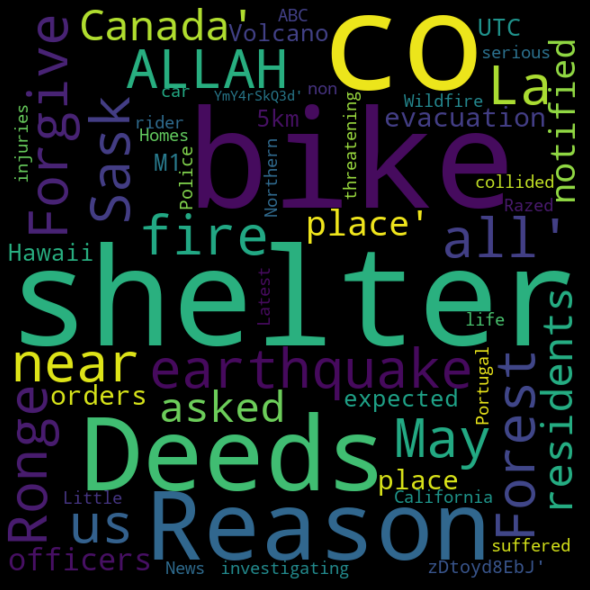

In [4]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
texts = train_df['text'].loc[train_df['target']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(texts))
fig = plt.figure(
    figsize =(12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

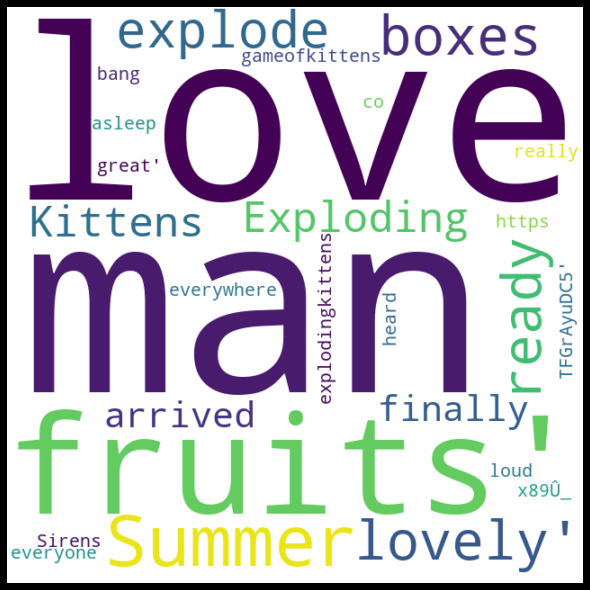

In [5]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
texts = train_df['text'].loc[train_df['target']==0].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(texts))
fig = plt.figure(
    figsize =(12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [6]:
puncts = [
    ',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&',
    '/', '[', ']', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£',
    '·', '_', '{', '}', '©', '^', '®', '`', '→', '°', '€', '™', '›',
    '♥', '←', '×', '§', '″', '′', 'Â', '█', 'à', '…', '“', '★', '”',
    '–', '●', 'â', '►', '−', '¢', '¬', '░', '¶', '↑', '±',  '▾',
    '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '⊕', '▼',
    '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
    'è', '¸', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
    '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
    '¹', '≤', '‡', '₹', '´'
]

In [7]:
%%time
def clean_punct(x):
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x
train_df["text"] = train_df["text"].apply(lambda x: clean_punct(x))

CPU times: user 60.9 ms, sys: 1.6 ms, total: 62.5 ms
Wall time: 63.2 ms


In [8]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

In [9]:
train_df["text"] = train_df["text"].apply(lambda x: remove_URL(x))
train_df["text"] = train_df["text"].apply(lambda x: remove_emoji(x))
train_df["text"] = train_df["text"].apply(lambda x: remove_html(x))

In [10]:
max_features = 20000
max_text_length = 400

In [11]:
x = train_df['text'].values
print(x)

['Our Deeds are the Reason of this  # earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask .  Canada'
 "All residents asked to  ' shelter in place '  are being notified by officers .  No other evacuation or shelter in place orders are expected"
 ...
 'M1 . 94  [ 01 : 04 UTC ]  ? 5km S of Volcano Hawaii .  http :  /  / t . co / zDtoyd8EbJ'
 'Police investigating after an e - bike collided with a car in Little Portugal .  E - bike rider suffered serious non - life threatening injuries . '
 'The Latest :  More Homes Razed by Northern California Wildfire  -  ABC News http :  /  / t . co / YmY4rSkQ3d']


In [12]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val = sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

In [13]:
!wget http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_300d.txt.bz2


--2020-11-07 11:10:10--  http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_300d.txt.bz2
Resolving wikipedia2vec.s3.amazonaws.com (wikipedia2vec.s3.amazonaws.com)... 52.219.1.37
Connecting to wikipedia2vec.s3.amazonaws.com (wikipedia2vec.s3.amazonaws.com)|52.219.1.37|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2558818654 (2.4G) [application/x-bzip2]
Saving to: ‘enwiki_20180420_300d.txt.bz2’

enwiki_20180420_300 100%[===================>]   2.38G  18.5MB/s    in 2m 14s  

2020-11-07 11:12:25 (18.3 MB/s) - ‘enwiki_20180420_300d.txt.bz2’ saved [2558818654/2558818654]



In [14]:
!bzip2 -d "/content/enwiki_20180420_300d.txt.bz2"

In [15]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2020-11-07 11:23:45--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.11.150
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.11.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  78.9MB/s    in 25s     

2020-11-07 11:24:10 (62.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [26]:
import gensim
#Load pretrained vectors from Google
model = gensim.models.KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [27]:
model.save("word2vec.model")

In [28]:
model.word_vec

<bound method WordEmbeddingsKeyedVectors.word_vec of <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x7f1ed8682400>>

In [31]:
from gensim.models.keyedvectors import KeyedVectors

model = KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin.gz', binary=True)
model.save_word2vec_format('/content/GoogleNews-vectors-negative300.txt', binary=False)

In [13]:
embedding_dim = 300
embeddings_index = dict()
f = open('/content/GoogleNews-vectors-negative300.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors.')

Found 3000000 word vectors.


In [14]:
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items():
  if index > max_features -1:
      break
  else:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

In [15]:
#from google.colab import drive
#drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [16]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(
                    embedding_matrix),
                    trainable=False))
model.add(Dropout(0.2))

In [17]:
filters = 250
kernel_size = 3
hidden_dims = 250

In [18]:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 5,
                 padding='valid',
                 activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         6000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 300)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         225250    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 250)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               6

In [19]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
y = train_df['target'].values
print(y)

[1 1 1 ... 1 1 1]


In [21]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y,
                                                  test_size=0.15, random_state=1)

In [22]:
%%time
batch_size = 32
epochs = 100

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data= (x_val, y_val))

Epoch 1/100
203/203 [==============================] - 111s 545ms/step - loss: 0.4801 - accuracy: 0.7769 - val_loss: 0.4646 - val_accuracy: 0.7986
Epoch 2/100
203/203 [==============================] - 111s 546ms/step - loss: 0.4067 - accuracy: 0.8209 - val_loss: 0.4471 - val_accuracy: 0.8100
Epoch 3/100
203/203 [==============================] - 115s 566ms/step - loss: 0.3462 - accuracy: 0.8546 - val_loss: 0.4553 - val_accuracy: 0.8152
Epoch 4/100
203/203 [==============================] - 110s 543ms/step - loss: 0.2866 - accuracy: 0.8855 - val_loss: 0.4894 - val_accuracy: 0.8030
Epoch 5/100
203/203 [==============================] - 111s 545ms/step - loss: 0.2186 - accuracy: 0.9169 - val_loss: 0.7665 - val_accuracy: 0.7531
Epoch 6/100
203/203 [==============================] - 111s 544ms/step - loss: 0.1689 - accuracy: 0.9379 - val_loss: 0.6474 - val_accuracy: 0.8065
Epoch 7/100
203/203 [==============================] - 110s 543ms/step - loss: 0.1249 - accuracy: 0.9543 - val_loss: 0

In [23]:
val_predictions = model.predict(x_val, verbose=1, batch_size=32)

36/36 [==============================] - 6s 166ms/step


In [24]:
val_predictions.shape

(1142, 1)

In [25]:
val_predictions

array([[9.9689263e-01],
       [7.0362049e-01],
       [4.4155791e-01],
       ...,
       [9.4749266e-05],
       [1.0000000e+00],
       [9.6783364e-01]], dtype=float32)

In [26]:
from sklearn import metrics
import seaborn as sns

val_predictions_int = val_predictions.round().astype('int')

In [27]:
from sklearn.metrics import f1_score
f1_score(y_val, val_predictions_int, zero_division=1)

0.7518479408658922

In [28]:
# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

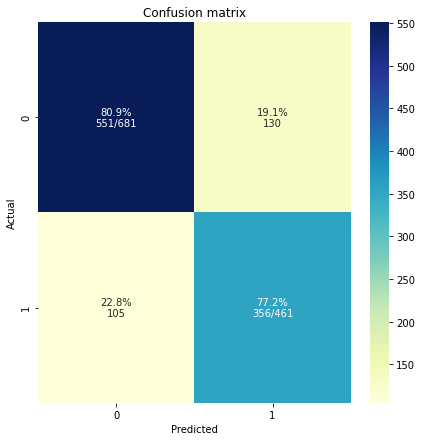

In [29]:
from sklearn.metrics import classification_report,confusion_matrix
# Showing Confusion Matrix
plot_cm(val_predictions_int, y_val, 'Confusion matrix', figsize=(7,7))

In [30]:
#Import Test dataset
test_df = pd.read_csv('/content/test.csv')

In [31]:
test_df.shape

(3263, 4)

In [32]:
test_df["text"] = test_df["text"].apply(lambda x: clean_punct(x))
test_df["text"] = test_df["text"].apply(lambda x: remove_URL(x))
test_df["text"] = test_df["text"].apply(lambda x: remove_emoji(x))
test_df["text"] = test_df["text"].apply(lambda x: remove_html(x))

In [33]:
x_test = test_df['text'].values

In [34]:
def predict_writesub(x_test):
    x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
    x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)
    predictions = model.predict(x_testing, verbose=1, batch_size=32)
    submission = pd.DataFrame({'id': test_df['id'], 'target': predictions.ravel()})
    submission['target'] = np.where(submission['target']  > 0.5, 1, 0)
    submission.to_csv('submit.csv', index = False)
    print(submission.head())
    
predict_writesub(x_test)

102/102 [==============================] - 17s 171ms/step
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


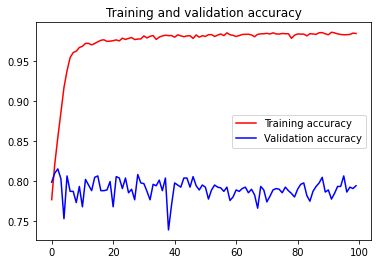

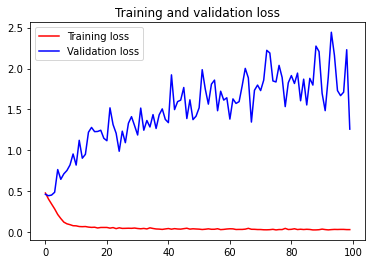

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()